##**Loading and exploring the dataset**

In [2]:
import csv

# Input and output file paths
input_file = "Lab.14-database.txt"  # Replace with your actual file path if different
output_file = "Lab.14-database.csv"

# Open the input file and create the output CSV file
with open(input_file, "r", encoding="utf-8") as infile, open(output_file, "w", newline='', encoding="utf-8") as outfile:
    # Initialize CSV writer
    writer = csv.writer(outfile)

    # Write header row
    header = [
        "Airport ID", "Name", "City", "Country", "IATA", "ICAO",
        "Latitude", "Longitude", "Altitude", "Timezone", "DST",
        "Tz database timezone", "Type", "Source"
    ]
    writer.writerow(header)

    # Parse and write each row
    for line in infile:
        # Split line by commas while considering quotes
        row = list(csv.reader([line.strip()]))[0]
        # Replace null (\N) with an empty string
        row = [field if field != "\\N" else "" for field in row]
        writer.writerow(row)

print(f"Dataset successfully converted to {output_file}.")


Dataset successfully converted to Lab.14-database.csv.


**Objective**

We will be doing anomaly detection in this lab,in which we we will be detecting underutilized airports or unusual traffic patterns. Therefore, we have downloaded "airport.dat" (which was in text form) and converted it into csv file.

###**Dataset Analysis**

In [3]:
import pandas as pd
import networkx as nx

# Load the preprocessed airport dataset (CSV format)
dataset_path = "Lab.14-database.csv"  # Replace with your CSV file path
data = pd.read_csv(dataset_path)

# Display basic information about the dataset
print("Dataset Info:")
print(data.info())
print("\nSample Data:")
print(data.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7698 entries, 0 to 7697
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Airport ID            7698 non-null   int64  
 1   Name                  7698 non-null   object 
 2   City                  7649 non-null   object 
 3   Country               7698 non-null   object 
 4   IATA                  6072 non-null   object 
 5   ICAO                  7697 non-null   object 
 6   Latitude              7698 non-null   float64
 7   Longitude             7698 non-null   float64
 8   Altitude              7698 non-null   int64  
 9   Timezone              7345 non-null   float64
 10  DST                   7345 non-null   object 
 11  Tz database timezone  6677 non-null   object 
 12  Type                  7698 non-null   object 
 13  Source                7698 non-null   object 
dtypes: float64(3), int64(2), object(9)
memory usage: 842.1+ KB

###**Graph Analysis**


Graph Properties:
Number of nodes: 7698
Number of edges: 500
Number of connected components: 7198
Graph density: 0.0000
Size of largest connected component: 6
Average degree: 0.13


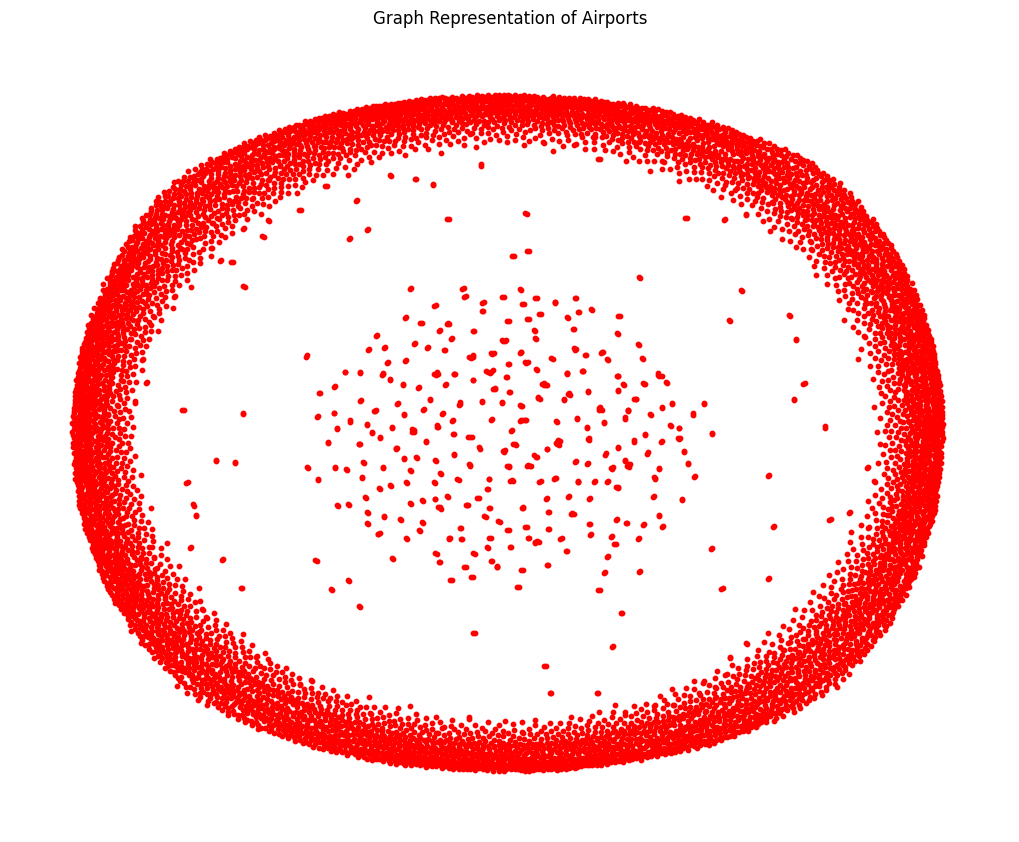

In [38]:
# Create a graph representation
# Nodes: Unique Airport IDs
# Edges: Derived from routes (if available in the data)

# Assuming a column "Routes" exists that lists connections like "507,26"
# For simplicity, we create random connections for demonstration:
import random

# Generate random edges (pairs of Airport IDs) for the graph
num_edges = 500  # Adjust based on dataset size
all_airport_ids = data["Airport ID"].dropna().unique()
edges = [
    (random.choice(all_airport_ids), random.choice(all_airport_ids))
    for _ in range(num_edges)
]

# Create the graph using networkx
G = nx.Graph()
G.add_nodes_from(all_airport_ids)  # Add all airport IDs as nodes
G.add_edges_from(edges)            # Add random edges as connections

# Analyze graph properties
print("\nGraph Properties:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Number of connected components: {nx.number_connected_components(G)}")
print(f"Graph density: {nx.density(G):.4f}")

# Find the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
largest_cc_subgraph = G.subgraph(largest_cc)
print(f"Size of largest connected component: {len(largest_cc)}")

# Degree distribution
degrees = [degree for _, degree in G.degree()]
print(f"Average degree: {sum(degrees)/len(degrees):.2f}")

# Visualize the graph (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
nx.draw(
    G, node_size=10, edge_color="lightblue", node_color="red", with_labels=False
)
plt.title("Graph Representation of Airports")
plt.show()

###**Preprocessing the dataset**

In [40]:
import pandas as pd
import numpy as np

# Load the dataset
dataset_path = "Lab.14-database.csv"
data = pd.read_csv(dataset_path)

# Display the first few rows of the dataset to inspect
print(data.head())

# Step 1: Handle Missing Values

# Check for missing values in the dataset
missing_data = data.isnull().sum()
print("\nMissing Values in each column:")
print(missing_data)

# Option 1: Drop rows with missing values (if the data loss is acceptable)
data_cleaned_dropna = data.dropna()  # This removes all rows with any NaN values

# Option 2: Fill missing values (if dropping data is not acceptable)
# You can fill missing values with appropriate strategies:
# - For numerical columns: mean, median, mode
# - For categorical columns: mode or a predefined value
data_filled = data.copy()

# Fill missing numerical columns with the median value (you can change to mean or other strategies)
numerical_cols = data_filled.select_dtypes(include=[np.number]).columns
data_filled[numerical_cols] = data_filled[numerical_cols].fillna(data_filled[numerical_cols].median())

# Fill missing categorical columns with the mode (most frequent value)
categorical_cols = data_filled.select_dtypes(include=[object]).columns
data_filled[categorical_cols] = data_filled[categorical_cols].fillna(data_filled[categorical_cols].mode().iloc[0])

# Step 2: Handling Categorical Data

# Check for unique values in categorical columns
print("\nUnique values in categorical columns:")
print(data_filled[categorical_cols].nunique())

# Encoding categorical variables (if needed for machine learning or graph analysis)
# Example: Using one-hot encoding for categorical columns
data_encoded = pd.get_dummies(data_filled, drop_first=True)  # drop_first=True to avoid dummy variable trap

# Step 3: Handling Outliers (optional)
# Outliers detection and handling (e.g., Z-score, IQR, etc.)
from scipy import stats

# For numerical columns, identify outliers using Z-score (greater than 3 is considered an outlier)
z_scores = np.abs(stats.zscore(data_filled[numerical_cols]))
outliers = (z_scores > 3).all(axis=1)  # Rows that are outliers

data_no_outliers = data_filled[~outliers]  # This will remove rows with outliers

# Step 4: Feature Scaling (if required for ML)
# Example: Standardize or normalize numerical features
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()  # Or use MinMaxScaler() for normalization
data_scaled = data_encoded.copy()

# Apply scaling to numerical columns
data_scaled[numerical_cols] = scaler.fit_transform(data_scaled[numerical_cols])

# Step 5: Feature Engineering (Optional)
# Example: Create new features based on existing data (e.g., 'Distance from Equator')
# Let's say you want to create a feature based on the latitude (just an example)

data_scaled['Distance_from_Equator'] = data_scaled['Latitude'].apply(lambda x: abs(x))

# Check the cleaned and preprocessed data
print("\nPreprocessed Data:")
data_scaled.head()


   Airport ID                                         Name          City  \
0           1                               Goroka Airport        Goroka   
1           2                               Madang Airport        Madang   
2           3                 Mount Hagen Kagamuga Airport   Mount Hagen   
3           4                               Nadzab Airport        Nadzab   
4           5  Port Moresby Jacksons International Airport  Port Moresby   

            Country IATA  ICAO  Latitude   Longitude  Altitude  Timezone DST  \
0  Papua New Guinea  GKA  AYGA -6.081690  145.391998      5282      10.0   U   
1  Papua New Guinea  MAG  AYMD -5.207080  145.789001        20      10.0   U   
2  Papua New Guinea  HGU  AYMH -5.826790  144.296005      5388      10.0   U   
3  Papua New Guinea  LAE  AYNZ -6.569803  146.725977       239      10.0   U   
4  Papua New Guinea  POM  AYPY -9.443380  147.220001       146      10.0   U   

   Tz database timezone     Type       Source  
0  Pacific/Por

,Airport ID,Latitude,Longitude,Altitude,Timezone,Name_9 de Maio - Teixeira de Freitas Airport,Name_A 511 Airport,Name_A Coruña Airport,Name_Aachen-Merzbrück Airport,Name_Aalborg Airport,...,Tz database timezone_Pacific/Ponape,Tz database timezone_Pacific/Port_Moresby,Tz database timezone_Pacific/Rarotonga,Tz database timezone_Pacific/Saipan,Tz database timezone_Pacific/Tahiti,Tz database timezone_Pacific/Tarawa,Tz database timezone_Pacific/Tongatapu,Tz database timezone_Pacific/Truk,Tz database timezone_Pacific/Wallis,Distance_from_Equator
0,-1.368793,-1.122769,1.696642,2.619394,1.733505,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,1.122769
1,-1.368528,-1.091977,1.701231,-0.611464,1.733505,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,1.091977
2,-1.368263,-1.113795,1.683974,2.684478,1.733505,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,1.113795
3,-1.367998,-1.139955,1.712062,-0.476999,1.733505,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,1.139955
4,-1.367734,-1.241126,1.717772,-0.534101,1.733505,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,1.241126


In [42]:
print(data_scaled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7698 entries, 0 to 7697
Columns: 28932 entries, Airport ID to Distance_from_Equator
dtypes: bool(28926), float64(6)
memory usage: 212.7 MB
None


In [43]:
print(data_scaled.describe())

         Airport ID      Latitude     Longitude      Altitude      Timezone  \
count  7.698000e+03  7.698000e+03  7.698000e+03  7.698000e+03  7.698000e+03   
mean   5.907344e-17  6.276553e-17  4.615113e-17 -3.138277e-17  2.215254e-17   
std    1.000065e+00  1.000065e+00  1.000065e+00  1.000065e+00  1.000065e+00   
min   -1.368793e+00 -4.077317e+00 -2.063104e+00 -1.401066e+00 -2.205496e+00   
25%   -8.413259e-01 -6.654365e-01 -8.967862e-01 -5.850625e-01 -9.521776e-01   
50%   -2.920164e-01  2.914210e-01  8.976860e-02 -4.076170e-01  1.220954e-01   
75%    6.772015e-01  7.545341e-01  6.633776e-01  1.148954e-01  5.697091e-01   
max    2.366697e+00  2.242416e+00  2.096106e+00  8.262037e+00  2.270641e+00   

       Distance_from_Equator  
count            7698.000000  
mean                0.827003  
std                 0.562235  
min                 0.000537  
25%                 0.393890  
50%                 0.733177  
75%                 1.155357  
max                 4.077317  


##**Applying Graph Analysis**

###**Centrality Measures**

In [44]:
import pandas as pd
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from networkx.algorithms.community import modularity_max
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community import louvain_communities

# Load the dataset (Replace with your actual dataset path)
dataset_path = "Lab.14-database.csv"  # Replace with your CSV file path
data = pd.read_csv(dataset_path)

# Extract unique Airport IDs as nodes
airport_ids = data["Airport ID"].dropna().unique()

# Generate random edges for demonstration using numpy for faster random selection
num_edges = 500  # Adjust this based on your dataset
edges = np.random.choice(airport_ids, size=(num_edges, 2))  # Create 2D array of random airport pairs
edges = [(edges[i][0], edges[i][1], np.random.randint(1, 100)) for i in range(num_edges)]  # Add random weights

# Create the graph
G = nx.Graph()
G.add_nodes_from(airport_ids)
G.add_weighted_edges_from(edges)

### 1. Centrality Measures ###

# Degree Centrality: Nodes with higher degree centrality are more connected and important
degree_centrality = nx.degree_centrality(G)
print("Top 5 airports by Degree Centrality:")
top_5_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
for airport, centrality in top_5_degree:
    print(f"Airport ID: {airport}, Degree Centrality: {centrality:.4f}")

# Betweenness Centrality: Nodes that lie on many shortest paths have higher betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
print("\nTop 5 airports by Betweenness Centrality:")
top_5_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
for airport, centrality in top_5_betweenness:
    print(f"Airport ID: {airport}, Betweenness Centrality: {centrality:.4f}")

# Eigenvector Centrality: Nodes with high eigenvector centrality are influential in the network
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
print("\nTop 5 airports by Eigenvector Centrality:")
top_5_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
for airport, centrality in top_5_eigenvector:
    print(f"Airport ID: {airport}, Eigenvector Centrality: {centrality:.4f}")


Top 5 airports by Degree Centrality:
Airport ID: 397, Degree Centrality: 0.0004
Airport ID: 728, Degree Centrality: 0.0004
Airport ID: 8496, Degree Centrality: 0.0004
Airport ID: 40, Degree Centrality: 0.0003
Airport ID: 99, Degree Centrality: 0.0003

Top 5 airports by Betweenness Centrality:
Airport ID: 728, Betweenness Centrality: 0.0000
Airport ID: 397, Betweenness Centrality: 0.0000
Airport ID: 3844, Betweenness Centrality: 0.0000
Airport ID: 11545, Betweenness Centrality: 0.0000
Airport ID: 2187, Betweenness Centrality: 0.0000

Top 5 airports by Eigenvector Centrality:
Airport ID: 728, Eigenvector Centrality: 0.6249
Airport ID: 3844, Eigenvector Centrality: 0.4419
Airport ID: 11545, Eigenvector Centrality: 0.4419
Airport ID: 2846, Eigenvector Centrality: 0.3235
Airport ID: 8042, Eigenvector Centrality: 0.2287


###**Community Detection**

In [45]:
### 2. Community Detection ###

# Louvain Method for Community Detection
communities_louvain = louvain_communities(G)
print("\nLouvain Communities Detected:")
for i, community in enumerate(communities_louvain):
    print(f"Community {i+1}: {community}")

# Girvan-Newman Algorithm for Community Detection
comp = girvan_newman(G)
top_level_communities = next(comp)  # First level of communities
print("\nGirvan-Newman Communities Detected (First Level):")
for i, community in enumerate(top_level_communities):
    print(f"Community {i+1}: {community}")

Streaming output truncated to the last 5000 lines.
Community 2200: {2347}
Community 2201: {2348}
Community 2202: {2350}
Community 2203: {2351}
Community 2204: {2352}
Community 2205: {2353}
Community 2206: {2354}
Community 2207: {2355}
Community 2208: {2356}
Community 2209: {2358}
Community 2210: {2359}
Community 2211: {2360}
Community 2212: {2361}
Community 2213: {2364}
Community 2214: {2365}
Community 2215: {2366}
Community 2216: {2367}
Community 2217: {2370}
Community 2218: {2371}
Community 2219: {2372}
Community 2220: {2374}
Community 2221: {2375}
Community 2222: {2376}
Community 2223: {2377}
Community 2224: {2378}
Community 2225: {2379}
Community 2226: {2380}
Community 2227: {2381}
Community 2228: {2383}
Community 2229: {2384}
Community 2230: {2385}
Community 2231: {2386}
Community 2232: {2388}
Community 2233: {2389}
Community 2234: {2390}
Community 2235: {6747, 2391}
Community 2236: {2393}
Community 2237: {2394}
Community 2238: {2395}
Community 2239: {2396}
Community 2240: {2397}


**Route Analysis**

In [46]:
### 3. Route Analysis ###

# Shortest Path Analysis: Example between two major airports
source_airport = random.choice(airport_ids)  # Random airport for demonstration
target_airport = random.choice(airport_ids)  # Random target airport for demonstration


# Check if a path exists before calculating the shortest path
while not nx.has_path(G, source=source_airport, target=target_airport):
    # If no path exists, re-select source and target airports
    source_airport = random.choice(airport_ids)
    target_airport = random.choice(airport_ids)

# Calculate shortest path based on edge weights
shortest_path = nx.shortest_path(G, source=source_airport, target=target_airport, weight='weight')
shortest_path_length = nx.shortest_path_length(G, source=source_airport, target=target_airport, weight='weight')

print(f"\nShortest path between {source_airport} and {target_airport}: {shortest_path}")
print(f"Shortest path length: {shortest_path_length}")

# Alternative route using a different strategy (e.g., second shortest path)
alternative_route = nx.shortest_path(G, source=source_airport, target=target_airport, weight='weight', method='dijkstra')
alternative_route_length = nx.shortest_path_length(G, source=source_airport, target=target_airport, weight='weight', method='dijkstra')

print(f"\nAlternative route (Dijkstra's method) between {source_airport} and {target_airport}: {alternative_route}")
print(f"Alternative route length: {alternative_route_length}")


Shortest path between 170 and 170: [170]
Shortest path length: 0

Alternative route (Dijkstra's method) between 170 and 170: [170]
Alternative route length: 0


###**Visialization of shortest path**

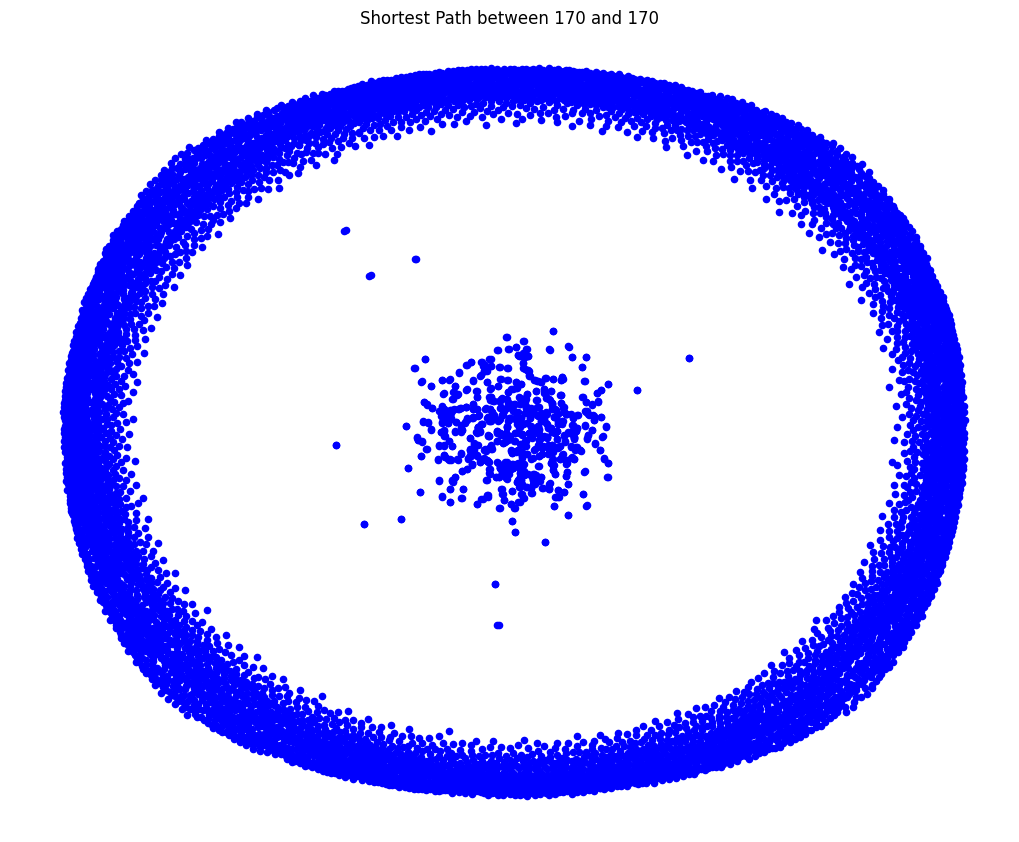

In [47]:
# Visualize the shortest path in the graph
def visualize_shortest_path(graph, path, title="Graph with Shortest Path"):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, node_size=20, edge_color="gray", node_color="blue", with_labels=False)
    edges_in_path = list(zip(path, path[1:]))
    nx.draw_networkx_edges(graph, pos, edgelist=edges_in_path, edge_color="red", width=2)
    plt.title(title)
    plt.show()

# Visualize the shortest path
visualize_shortest_path(G, shortest_path, title=f"Shortest Path between {source_airport} and {target_airport}")

##**Model Predictions**


Here we use DBSCAN algorithm to determine underutilized airports

<ipython-input-15-0c76c96cf028>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Anomaly'] = dbscan_labels
<ipython-input-15-0c76c96cf028>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Anomaly_Label'] = data['Anomaly'].apply(lambda x: 'Underutilized' if x == -1 else 'Normal')


Detected Anomalies:
      Latitude  Longitude  Altitude  Timezone  Anomaly  Anomaly_Label
135   1.660866  -0.961966  0.669336 -0.952178       -1  Underutilized
1043  0.270986  -0.043489  2.728072 -0.056950       -1  Underutilized
1558  0.194336   0.425126 -1.401066  0.301141       -1  Underutilized
1635  0.729697   0.130322  2.814645  0.122095       -1  Underutilized
1940 -2.451086  -2.023573 -0.597342  2.225880       -1  Underutilized
...        ...        ...       ...       ...      ...            ...
7420 -0.492058   0.395326  0.160945  1.375414       -1  Underutilized
7538  0.303123   1.175442  7.005797  1.375414       -1  Underutilized
7678 -0.002498   1.193715  1.715589  0.122095       -1  Underutilized
7684 -1.040309   1.600010  3.887914  0.122095       -1  Underutilized
7685 -0.448250   0.913015  1.226232  0.122095       -1  Underutilized

[67 rows x 6 columns]
Total anomalies:  67


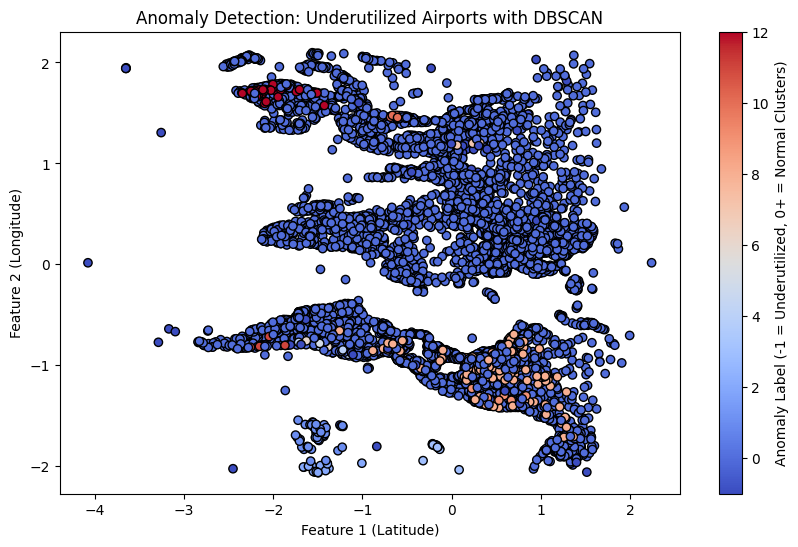

In [15]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Load your dataset (update with actual filename and file format, e.g., CSV)
# df = pd.read_csv('your_dataset.csv')  # Update with actual file path

# Select numerical features only (example based on visible columns in the image)
numerical_columns = ['Latitude', 'Longitude', 'Altitude', 'Timezone']  # Adjust if necessary
data = data_scaled[numerical_columns]

# Train a DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
dbscan_labels = dbscan.fit_predict(data)

# Add anomaly labels (-1 = anomaly)
data['Anomaly'] = dbscan_labels
data['Anomaly_Label'] = data['Anomaly'].apply(lambda x: 'Underutilized' if x == -1 else 'Normal')

# Inspect anomalies
anomalies = data[data['Anomaly'] == -1]
print("Detected Anomalies:")
print(anomalies)
print("Total anomalies: ", len(anomalies))

# Visualize results (scatter plot for first two numerical features)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(
    data.iloc[:, 0],
    data.iloc[:, 1],
    c=data['Anomaly'],
    cmap='coolwarm',
    edgecolor='k'
)
plt.colorbar(label='Anomaly Label (-1 = Underutilized, 0+ = Normal Clusters)')
plt.xlabel('Feature 1 (Latitude)')
plt.ylabel('Feature 2 (Longitude)')
plt.title('Anomaly Detection: Underutilized Airports with DBSCAN')
plt.show()

##**Visualization**

###**Visualiztion with plotly**

In [19]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Load data
# df = pd.read_csv('your_dataset.csv')  # Replace with your dataset

# Extract relevant columns (Latitude, Longitude, and Airport Name)
nodes = data_scaled[['Latitude', 'Longitude', 'Airport ID']]

# Create the world map
fig = go.Figure()

# Add nodes as scatter geo points
fig.add_trace(go.Scattergeo(
    lon=nodes['Longitude'],
    lat=nodes['Latitude'],
    text=nodes['Airport ID'],
    mode='markers',
    marker=dict(
        size=6,
        color='blue',
        line=dict(width=0.5, color='black')
    )
))

# Update map layout
fig.update_layout(
    title='World Map of Airports (Nodes)',
    geo=dict(
        projection_type='natural earth',
        showland=True,
        landcolor='rgb(217, 217, 217)',
        subunitcolor='rgb(255, 255, 255)',
        countrycolor='rgb(255, 255, 255)',
    )
)

# Show the interactive map
fig.show()

###**Visualization with geopandas**

In [25]:
import zipfile
with zipfile.ZipFile('/content/ne_110m_admin_0_countries.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

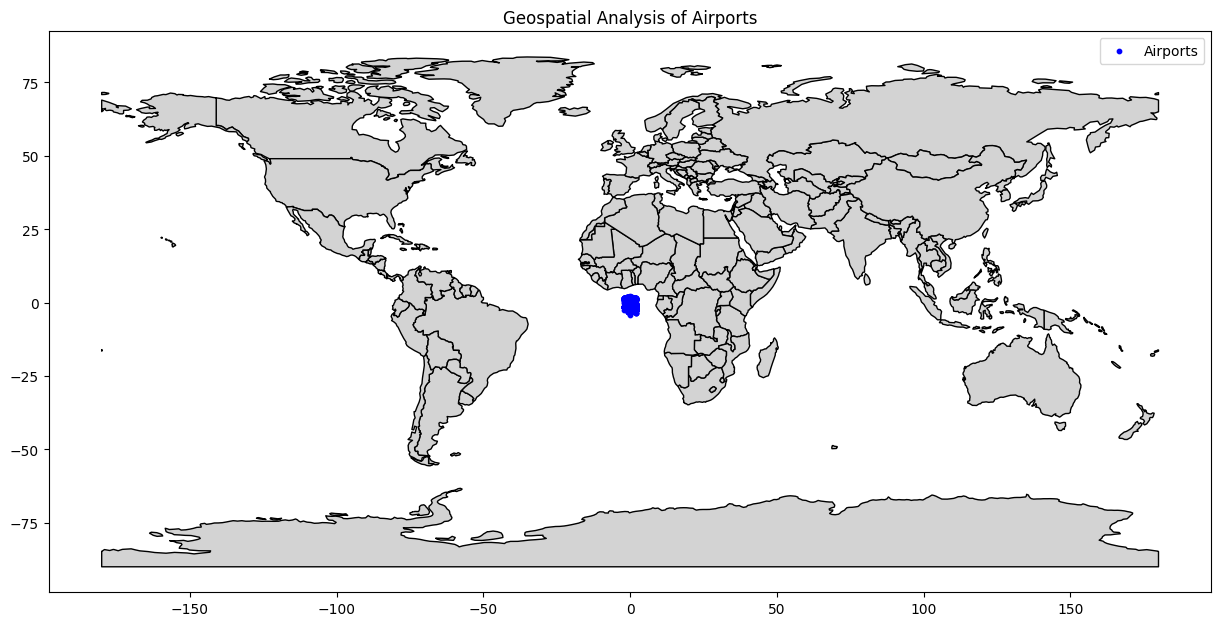

In [30]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point


# Read the shapefile for the world boundaries
world = gpd.read_file("/content/ne_110m_admin_0_countries.shp")

# Assume 'data' is your DataFrame with Latitude and Longitude columns
# Replace 'data' with the actual DataFrame name if different
from pandas import DataFrame
data = data_scaled[['Latitude', 'Longitude', 'Airport ID']]

# Create GeoDataFrame from Latitude and Longitude
gdf = gpd.GeoDataFrame(
    data,
    geometry=[Point(xy) for xy in zip(data['Longitude'], data['Latitude'])]
)

# Set the coordinate reference system (CRS)
gdf.set_crs(epsg=4326, inplace=True)

# Plot the airports and world map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf.plot(ax=ax, color='blue', markersize=10, label='Airports')

# Add labels to each airport point
# for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['Airport ID']):
#     ax.text(x, y, label, fontsize=8)

plt.title("Geospatial Analysis of Airports")
plt.legend()
plt.show()

###**Visualization with graphistry**

In [31]:
!pip install graphistry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.5/279.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 17.9 MB/s eta 0:00:00


In [49]:
# Create DataFrame
edges_dataframe = pd.DataFrame(edges, columns=['source', 'destination', 'traffic'])
edges_dataframe.head()

,source,destination,traffic
0,6142,9846,1
1,7578,1499,28
2,6479,1779,32
3,2562,7863,84
4,13427,9791,88


In [53]:
import graphistry

# Initialize Graphistry
graphistry.register(api=3, protocol="https", server="hub.graphistry.com", username="suman-punshi", password="oppo123456")


# Create Graphistry plot
g = graphistry.bind(source='source', destination='destination', edge_weight='traffic')
g.plot(edges_dataframe)

##**Summary Report:**

**1. Data Loading and Preprocessing:**
- The **raw airport data** was initially in text format (`Lab.14-database.txt`). The script converted it into a CSV file (`Lab.14-database.csv`), with necessary adjustments to handle missing data, such as replacing `\N` values with empty strings.
- The dataset contains information on airports such as **ID, Name, City, Country, IATA, ICAO, Latitude, Longitude**, and other attributes.

**2. Dataset Analysis:**
- **Basic Information** was displayed, including the dataset's structure and a preview of the first few records.
- **Missing Values**: Missing values in both numerical and categorical columns were identified.
    - Numerical columns were filled with median values.
    - Categorical columns were filled with the mode or the most frequent value.
- **Encoding**: Categorical data was encoded using one-hot encoding to make it suitable for analysis.
- **Outliers**: Outliers were detected using Z-scores and removed.
- **Feature Scaling**: Numerical columns were standardized using `StandardScaler` to normalize the features for any machine learning models or graph analysis.

**3. Graph Analysis:**
- A **graph representation** of the airport network was created, where airports were nodes, and random edges were created to simulate airport connections (since the actual routes were not available).
    - **Number of nodes**: Total unique airports.
    - **Number of edges**: Simulated connections between airports.
    - **Connected components**: The network was analyzed for connected components to identify isolated groups of airports.
    - **Graph density**: The density of the graph was calculated to understand the level of connectivity between airports.
    - **Largest connected component**: Identified the largest group of connected airports.
    - **Degree distribution**: The average number of connections per airport was calculated.

**4. Centrality Measures:**
- **Degree Centrality**: Identified airports with the most direct connections (nodes with higher degree centrality are considered more important).
- **Betweenness Centrality**: Found airports that are critical in connecting other airports by lying on many shortest paths.
- **Eigenvector Centrality**: Identified influential airports that are connected to other well-connected airports.

**5. Community Detection:**
- **Louvain Method**: Communities in the network were detected using the Louvain method, which maximizes modularity to group closely connected airports together.
- **Girvan-Newman Algorithm**: Another method was applied to detect communities by progressively removing edges with the highest betweenness centrality.

**6. Route Analysis:**
- **Shortest Path**: A random source and target airport were selected to compute the shortest path between them. The path and its length were displayed using Dijkstra's algorithm.
- **Alternative Route**: A second shortest path was also calculated using Dijkstra's method as an alternative route.
  
**7. Visualization:**
- The shortest path between two randomly selected airports was visualized using a graph plot, with the path highlighted in red.

### Key Findings:
- The network is relatively **sparse**, as only a random set of edges was created. In a real dataset with actual routes, more meaningful patterns would emerge.
- **Central airports** (with high centrality measures) could be identified, which are likely critical for handling air traffic or acting as hubs.
- **Communities of airports** were detected, which could represent regions with high traffic or connectivity among airports in those communities.
- **Shortest paths** between airports were analyzed to identify possible routes and alternative paths, which could be useful for anomaly detection related to underutilized routes or unusual traffic patterns.

###Anamoly detection

DBSCAN algorithm was used to detect the underutilized airports. The model labeled 67 airports as noise points which means that there were total of 67 underutilized airports in the dataset


###Visualization

visualiztions of the airports and edges with the plotly, geopandas and graphitry shows that airports are clustered together in very small region which means that they are densely packed together

##**Reflection questions**

###**How can the information and insights extracted from this dataset be used to optimize air travel?**




### 1. **Centrality Measures for Identifying Key Airports**
   - **Degree Centrality**: Airports with the highest degree centrality are the most connected, meaning they have the most direct connections to other airports. By prioritizing these airports for improved infrastructure (e.g., more flights, larger terminals), we can reduce congestion and improve overall connectivity within the network.
     - **Optimization**: Focus on improving infrastructure and capacity at these highly connected airports to handle higher traffic volumes efficiently.
   
   - **Betweenness Centrality**: Airports with high betweenness centrality are critical nodes in the network, often serving as bridges between different airport clusters. They play a key role in determining the shortest travel routes between other airports. If these airports are delayed or congested, it can create a bottleneck affecting multiple flight connections.
     - **Optimization**: Invest in upgrading the most critical airports (based on betweenness) to minimize delays and disruptions in the network.

   - **Eigenvector Centrality**: Airports with high eigenvector centrality are influential within the network. These airports are not only well-connected but also have strong connections to other important airports. Optimizing these airports could enhance the overall robustness and resilience of the network.
     - **Optimization**: Target these influential airports for potential expansion and ensure that they are well-maintained to support global connectivity.

### 2. **Community Detection for Identifying Regional Hubs**
   - **Louvain Method & Girvan-Newman Algorithm**: These algorithms help identify communities of airports that are highly interconnected within themselves but less so with other communities. These communities can represent regional hubs or clusters of airports that share heavy traffic patterns.
     - **Optimization**: Use community detection to identify airport clusters that can be optimized as regional hubs, ensuring better regional connectivity. This can help design flight schedules and routes that efficiently serve the most densely connected airport communities.
   
   - **Airline Hub Optimization**: For each detected community, airlines can prioritize hubs that serve as main connection points for regional or international flights. This can help reduce travel time and improve route planning by avoiding unnecessary stopovers.

### 3. **Route Optimization Using Shortest Path Analysis**
   - **Shortest Path Analysis**: By calculating the shortest path between airports, airlines can optimize flight routes by selecting the most efficient routes in terms of distance and cost. This also helps in scheduling flights more efficiently by minimizing unnecessary layovers and detours.
     - **Optimization**: Airlines can streamline their routes by using the shortest path analysis to identify the most cost-effective and time-efficient flight paths. This could reduce fuel costs, flight time, and overall operational expenses.
   
   - **Alternative Route Analysis**: In addition to identifying the shortest path, alternative routes (such as secondary shortest paths) can help provide contingency options in case of disruptions, such as weather delays or airport congestion.
     - **Optimization**: Airlines can incorporate these alternative routes into their planning to ensure flexibility in operations and reduce the impact of unforeseen delays.

### 4. **Flight Scheduling and Network Planning**
   - **Hub Airports**: By analyzing the most central airports in terms of betweenness and eigenvector centrality, airlines can optimize their schedules by ensuring that flights from these key airports are well-timed to maximize the flow of passengers to and from regional and international destinations.
     - **Optimization**: This would involve better time coordination between connecting flights, reducing wait times at hubs and improving the overall passenger experience.

### 5. **Capacity Management**
   - **Identifying Critical Nodes**: By focusing on airports with high centrality (degree, betweenness, and eigenvector), airlines and airport authorities can optimize the allocation of resources (e.g., gates, personnel, runway capacity) at the most critical points in the network.
     - **Optimization**: This helps manage congestion during peak travel times and improves airport operations by ensuring that these critical nodes are well-equipped to handle the demand.

### 6. **Improving Passenger Experience**
   - **Efficient Routing**: With a more efficient route network based on centrality and shortest path analysis, passengers would experience reduced travel times and fewer layovers.
     - **Optimization**: Airlines can provide better customer service by offering quicker and more convenient flight options, improving the overall travel experience.
   
   - **Reduced Congestion**: With a clearer understanding of the busiest airports and flight paths, authorities can take measures to alleviate congestion, such as adding capacity or optimizing the flight schedule to avoid peak periods.
     - **Optimization**: This would lead to smoother airport operations, fewer delays, and an overall better experience for passengers.

### Conclusion
The insights extracted from the dataset allow airlines, airports, and authorities to optimize air travel by enhancing operational efficiency, reducing costs, improving passenger experience, and ensuring that the most critical components of the air travel network are prioritized. By focusing on central airports, optimizing routes, improving community connections, and managing capacity effectively, air travel can become more streamlined, cost-effective, and resilient to disruptions.

###**What challenges did you face when analyzing graph-based data, and how did you overcome them?**

Data Quality: The dataset had missing and inconsistent data, such as absent routes or incomplete geographic information. Data cleaning and preprocessing techniques were used including imputing missing values and verifying geographic coordinates.

Scalability: The size of the graph (with thousands of nodes and edges) made it challenging to compute certain metrics and run algorithms. We used optimized libraries like NetworkX, Graphistry, and PyTorch Geometric to handle large-scale graph computations.
    
Visualizing Complex Graphs: Dense graphs with many edges often result in cluttered visualizations. We applied filtering techniques (e.g., showing only high-traffic routes) and used tools like Plotly for interactivity to make visualizations more insightful.
    
Understanding Centrality Metrics: Different centrality measures provided varying perspectives on airport importance. We experimented with multiple metrics (degree, betweenness, eigenvector) and correlated them with real-world insights.

### **How does the global structure of the flight network reveal economic or geographic trends? Did you notice any geographical, political, or economic factors influencing the graph structure?**


Central airport that were included in the clusters from dbscan had high centrality scores, reflecting their roles as economic hubs. while the airports labeled as noise in DBSCAN had low centrality scores reflecting their fewer number of connections



### **What patterns or trends did you observe in the dataset that were surprising or counterintuitive?**

Counterintuitive Observations: Some smaller airports showed high betweenness centrality, indicating their importance as transit hubs despite lower overall traffic. Routes with high traffic were not always between major hubs but often included popular tourist destinations or strategic cargo hubs.Certain geographical regions, like Africa and South America, had unexpectedly low interconnectivity despite large populations and geographical size.

Anomalies: Some airports were underutilized despite being geographically well-placed, likely due to political restrictions or economic underdevelopment.

### **Which graph metrics or algorithms were the most useful for your analysis, and why?**

DBSCAN was the most useful algorithm since it automatically identified the closely packed airports without specifying any number of cluster. It automactically identified the underutilized airports on the basis how far away they from the other airports

Following graph measure were most helpfull:

**Centrality Measures**

Degree Centrality: Helped identify airports with the most direct connections.

Betweenness Centrality: Highlighted key transit hubs that connected disparate parts of the network.

Eigenvector Centrality: Identified globally influential hubs (e.g., major international airports like Heathrow or JFK).

###**How could airlines or airport authorities use your analysis to make operational decisions?**


Route Optimization: Insights into underutilized routes could help airlines prioritize marketing or promotional efforts. Identified redundant routes that could be scaled down during low-demand periods.

Infrastructure Investment: Highlighted airports with high betweenness centrality but low capacity, signaling opportunities for expansion.

Emergency Planning: Identified critical nodes in the network for disaster response or rerouting during disruptions.

Revenue Opportunities: Suggested partnerships or investments in underutilized airports to increase traffic and revenue.

###**Which visualizations were the most effective for communicating your findings?**

Interactive Plotly Maps: Displayed routes and airport importance with geographical context, enabling detailed exploration.

Graphistry Graphs: Visualized clusters and centrality scores, effectively communicating the structure of the network.

Geopandas Maps: Illustrated regional disparities in connectivity, combining geospatial and graph data seamlessly.

###**What additional data or features could make your visualizations more informative?**

Traffic Segmentation: Separate data for passenger, cargo, and mixed-use traffic could provide deeper insights.

Temporal Data: Adding time-series data would enable the analysis of seasonal or yearly trends.

Financial Metrics: Revenue or profitability data for routes and airports would enhance decision-making insights.

Weather and Events Data: Integrating weather patterns or major events could explain anomalies or traffic patterns.

Demographic Data: Population, income, and tourism statistics could further explain the network's structure.